### **Import Libraries**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
!pip install wandb

In [4]:
import wandb

## **Downloading Data**

In [5]:
from keras.datasets import fashion_mnist

## **Data pre-processing**

In [ ]:
# Split the data into training and testing sets
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

In [7]:
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

### **Q1**

---



60000


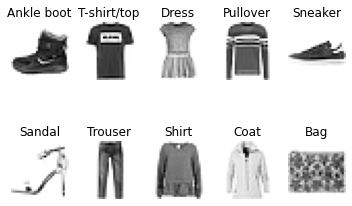

In [8]:
j=0 #j corresponds to the spot index in the subplot 
classSet=set()
Images=[]
print(trainX.shape[0])
for i in range(trainX.shape[0]):#i corresponds to the img index 
  if(j>9):
    break
  if(trainY[i] not in classSet):
    classSet.add(trainY[i])
    Images.append(wandb.Image(trainX[i], caption=class_labels[trainY[i]]))
    plt.subplot(2,5,j+1);j+=1
    plt.imshow(trainX[i], cmap="Greys")
    plt.axis('off') # off the axis
    plt.title('{}'.format(class_labels[trainY[i]]))

In [ ]:
wandb.login(key="a2e6402ce9fe2ebe1f01d5332c4fafa210b0dc0c")
pName = "Asg 1 Final"
run_obj=wandb.init( project=pName)

In [10]:
wandb.log({"Examples for each class": Images})

### **Q2**

---


## **Data Preprocessing**

In [11]:
trainX = trainX.reshape(trainX.shape[0], 784)
testX = testX.reshape(testX.shape[0], 784)
#feature Scaling
trainX=trainX/255.0
testX=testX/255.0
# Split the X_train into a training and validation sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=100)

## **Functions**

In [12]:
def softmax(a):
    return np.exp(a)/np.sum(np.exp(a),axis=0)

def grad_softmax(x):
    return softmax(x) * (1-softmax(x))

def sigmoid(a):
    return 1.0 / (np.exp(-a)+1.0)

def grad_sigmoid(a):
  return sigmoid(a)*(1-sigmoid(a))

def tanh(x):
    return np.tanh(x)

def grad_tanh(x):
    return (1 - (np.tanh(x)**2))

def relu(x):
    return np.maximum(0,x)

def grad_relu(x):
    return 1*(x>0) 

def identity(x):
  return x

def grad_identity(x):
  return np.ones(x.shape)

### **Model**

In [13]:
class model():
  def __init__(self,numLayers,numNeurons,optimizer,activation_funtion,initialization,l2_lambda, epsilon): 
    self.numLayers=numLayers+1 
    self.numHiddenLayers=self.numLayers-1
    self.numNeurons=numNeurons
    self.numClasses=10
    self.grad_w=[]
    self.grad_b=[]
    self.y_pred=[]
    self.u_w=0
    self.u_b=0
    self.m_w=0
    self.m_b=0
    self.W_L=[]
    self.b_L=[]
    self.optimizer=optimizer
    self.epsilon=epsilon
    if(activation_funtion=="sigmoid"):
      self.g=sigmoid
      self.grad_activation=grad_sigmoid
    if(activation_funtion=="ReLU"):
      self.g=relu
      self.grad_activation=grad_relu
    if(activation_funtion=="tanh"):
      self.g=tanh
      self.grad_activation=grad_tanh
    if(activation_funtion=="identity"):
      self.g=identity
      self.grad_activation=grad_identity     

    self.initialization=initialization
    self.l2_lambda=l2_lambda
    self.W=[]
    self.b=[]
      

  def initialize(self):
    #Initialising weights and Biases
    if self.initialization=="random":
      W = []
      W.append((np.random.uniform(-1,1,(784,self.numNeurons))))
      for i in range (2 , self.numHiddenLayers+1): 
        W.append((np.random.uniform(-1,1,(self.numNeurons,self.numNeurons))))
      W.append((np.random.uniform(-1,1,(self.numNeurons,self.numClasses))))
      self.W= np.array(W)

    if self.initialization=="Xavier":
      W = []
      W.append((np.random.uniform(-1,1,(784,self.numNeurons)))*np.sqrt(2/(784+self.numNeurons)))
      for i in range (2 , self.numHiddenLayers+1):
        W.append((np.random.uniform(-1,1,(self.numNeurons,self.numNeurons)))*np.sqrt(2/(self.numNeurons+self.numNeurons)))
      W.append((np.random.uniform(-1,1,(self.numNeurons,self.numClasses)))*np.sqrt(2/(self.numNeurons+self.numClasses)))
      self.W= np.array(W)

    b = []
    for i in range (1 , self.numLayers): 
      b.append(np.zeros((self.numNeurons,1)))
    b.append(np.zeros((self.numClasses,1)))
    self.b= np.array(b)

  def back_propagation(self,Y,batch_size,loss):
    """
    Compute gradients for the weight and bias parameters of the neural network
    using backpropagation.

    Arguments:
    Y -- the true labels
    batch_size -- the size of the mini-batch used for training
    loss -- the loss function used for training

    Returns:
    None (sets the gradients as object attributes)
    """
    grad_a=[None]*(self.numLayers)
    grad_b=[None]*(self.numLayers)
    grad_h=[None]*(self.numLayers)
    grad_w=[None]*(self.numLayers)
    oneHot_y=self.compute_oneHot_y(Y)

    h=self.activation
    a=self.preActivation
    W=self.W

    if loss=="cross_entropy":
      grad_a[self.numLayers-1]=self.y_pred-oneHot_y.T
    elif loss=="mean_squared_error":
      grad_a[self.numLayers-1]=(self.y_pred-oneHot_y.T)*grad_softmax(a[self.numLayers-1])

   
    for k in range (self.numLayers-1,-1,-1):
      grad_w[k]=np.matmul(grad_a[k], h[k].T)+self.l2_lambda*W[k].T
      grad_b[k]=np.sum(grad_a[k],axis=1,keepdims=True)/batch_size++self.l2_lambda*self.b[k]
      grad_h[k]=np.matmul(W[k],grad_a[k])

      if(k>0):
        grad_a[k-1] =grad_h[k] * self.grad_activation(a[k-1])
    self.grad_b,self.grad_w=grad_b,grad_w

  def feed_forward(self,X):
    """
    Perform a feedforward pass through the neural network, computing the activations and pre-activations for each layer.

    Arguments:
    X -- the input data for the neural network

    Returns:
    output -- the output of the neural network after the feedforward pass
    """
    a=[None]*(self.numLayers)
    h=[None]*(self.numLayers)
    k=0
    h[0]=X.T
    for k in range(0, self.numLayers-1): 
      a_k=self.b[k]+np.matmul(self.W[k].T,h[k]) 
      h_k=self.g(a_k)
      a[k]=(a_k)
      h[k+1]=(h_k)
    a[self.numLayers-1]=self.b[self.numLayers-1]+np.matmul(self.W[self.numLayers-1].T,h[self.numLayers-1])

    output=softmax(a[self.numLayers-1])

    self.activation,self.preActivation=h,a
    self.y_pred=output
    return output

  def train(self,trainX,trainY,valX, valY, batch_size,epochs,momentum,beta,beta_1,beta_2,neta,t,loss):
    """
    Train the neural network using the specified optimizer and hyperparameters.

    Args:
        trainX: The training data
        trainY: The training labels 
        valX: The validation data 
        valY: The validation labels
        batch_size: The number of examples in each batch for mini-batch gradient descent.
        epochs: The number of epochs to train for.
        momentum: The momentum parameter for momentum-based optimizers.
        beta: The beta parameter for RMSprop optimizer.
        beta_1: The beta_1 parameter for Adam and Nadam optimizers.
        beta_2: The beta_2 parameter for Adam and Nadam optimizers.
        neta: The learning rate parameter for all optimizers.
        t: The current iteration number.
        loss: The loss function to use during training.

    Returns:
        None
    """
    self.initialize()

    if self.optimizer=='nag':
      self.init_nag()
    epoch_train_loss=[]
    epoch_val_loss=[]

    for j in range(0,epochs):
      for i in range(0, trainX.shape[0],batch_size):
       
        if (self.optimizer == 'nag'):
          W_copy=self.W
          b_copy=self.b
          self.pre_update_nag(momentum)

        self.feed_forward(trainX[i:i+batch_size])
        self.back_propagation(trainY[i:i+batch_size],batch_size,loss)
        Grad_w=np.array(self.grad_w)
        for i in range(0,Grad_w.shape[0]):
          Grad_w[i]=Grad_w[i].T
        Grad_b=np.array(self.grad_b)

        if (self.optimizer == 'sgd'):
          self.update_sgd(neta,Grad_w,Grad_b)
        if (self.optimizer == 'momentum'): 
          self.update_mom(neta,momentum,Grad_w,Grad_b)
        if (self.optimizer == 'nag'):
          self.update_nag(neta,momentum,Grad_w,Grad_b,W_copy,b_copy)
        if (self.optimizer == 'rmsprop'):
          self.update_rmsprop(neta,beta,Grad_w,Grad_b)
        if (self.optimizer == 'adam'):
          self.update_adam(neta,beta_1,beta_2,Grad_w,Grad_b,t)
        if (self.optimizer == 'nadam'):
          self.update_nadam(neta,beta_1,beta_2,Grad_w,Grad_b,t)

        #self.update_new_optimiser()     The new optimiser algorithm will be called here

        t+=1

      self.feed_forward(trainX)
      train_acc=self.get_accuracy(trainY,self.y_pred.T)*100
      print("train accuracy: ",train_acc)
      train_loss=self.compute_loss(self.y_pred,self.compute_oneHot_y(trainY),trainX.shape[0],loss)
      val_loss, val_accuracy=self.test( valX, valY, beta, neta,loss)

      print("Epoch number: ", j+1, "\tTraining loss:", train_loss)
      epoch_train_loss.append(train_loss)
      epoch_val_loss.append(val_loss)
      wandb.log({"train_accuracy ": train_acc, "Training loss ": train_loss, "val_accuracy": val_accuracy, "val_loss":val_loss, "epochs ": j+1})

    plt.plot(list(range(len(epoch_train_loss))), epoch_train_loss, 'r', label="Training loss")
    plt.plot(list(range(len(epoch_val_loss))), epoch_val_loss, 'b', label="val loss")

    plt.title("Training Loss and Valdation loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()


  def test(self,valX,valY,beta,neta,loss):
    """Compute the loss and accuracy of the trained neural network on a validation set.
    """
    self.feed_forward(valX)

    val_loss=self.compute_loss(self.y_pred,self.compute_oneHot_y(valY),valX.shape[0],loss)
    val_accuracy=self.get_accuracy(valY,self.y_pred.T)*100

    print("val accuracy: ", val_accuracy, "\t val loss:", val_loss)
    return val_loss, val_accuracy

  def predict(self,TestX):
    """Predict output using the trained neural network on the test set.
    """
    output = self.feed_forward(TestX)
    return output

  def update_sgd(self,neta,Grad_w,Grad_b):
        self.W=self.W-neta*Grad_w
        self.b=self.b-neta*Grad_b
  
  def update_mom(self,neta,momentum,Grad_w,Grad_b):
        self.u_w=momentum*self.u_w+(1-momentum)*Grad_w
        self.u_b=momentum*self.u_b+(1-momentum)*Grad_b
        self.W=self.W-neta*self.u_w
        self.b=self.b-neta*self.u_b
  
  def update_nag(self,neta,momentum,Grad_w,Grad_b,W_copy,b_copy):
        self.W=W_copy
        self.b=b_copy
        self.u_w=momentum*self.u_w+(1-momentum)*Grad_w
        self.u_b=momentum*self.u_b+(1-momentum)*Grad_b
        self.W=self.W-neta*self.u_w
        self.b=self.b-neta*self.u_b

  def init_nag(self):
    ''' Initializing W_L and b_L for the nag aativation function'''
    W_L = []
    W_L.append((np.zeros([784,self.numNeurons])))
    for i in range (2 , self.numHiddenLayers+1): 
      W_L.append((np.zeros([self.numNeurons,self.numNeurons])))
    W_L.append((np.zeros([self.numNeurons,self.numClasses])))
    W_L= np.array(W_L)

    b_L = []
    for i in range (1 , self.numLayers):
      b_L.append(np.zeros((self.numNeurons,1)))
    b_L.append(np.zeros((self.numClasses,1)))
    b_L= np.array(b_L)
    self.W_L=W_L
    self.b_L=b_L

  def pre_update_nag(self,momentum):
    ''' Pre-update function for the nag aativation function'''
    self.W_L=self.W-momentum*self.u_w
    self.b_L=self.b-momentum*self.u_b
    self.W=self.W_L
    self.b=self.b_L

  def update_rmsprop(self,neta,beta,Grad_w,Grad_b):
        self.u_w=beta*self.u_w+(1-beta)*Grad_w*Grad_w
        self.u_b=beta*self.u_b+(1-beta)*Grad_b*Grad_b
        self.W=self.W-(neta/(self.u_w**0.5+self.epsilon))*Grad_w
        self.b=self.b-(neta/(self.u_b**0.5+self.epsilon))*Grad_b
  
  def update_adam(self,neta,beta_1,beta_2,Grad_w,Grad_b,t):

        self.m_w=beta_1*self.m_w+(1-beta_1)*Grad_w
        self.m_b=beta_1*self.m_b+(1-beta_1)*Grad_b

        self.u_w=beta_2*self.u_w+(1-beta_2)*Grad_w*Grad_w
        self.u_b=beta_2*self.u_b+(1-beta_2)*Grad_b*Grad_b

        m_w_hat=self.m_w/(1-beta_1**t)
        m_b_hat=self.m_b/(1-beta_1**t)

        self.W=self.W-(neta/(self.u_w**0.5+self.epsilon))*m_w_hat
        self.b=self.b-(neta/(self.u_b**0.5+self.epsilon))*m_b_hat

  def update_nadam(self,neta,beta_1,beta_2,Grad_w,Grad_b,t):

        self.m_w=beta_1*self.m_w+(1-beta_1)*Grad_w
        self.m_b=beta_1*self.m_b+(1-beta_1)*Grad_b

        self.u_w=beta_2*self.u_w+(1-beta_2)*Grad_w*Grad_w
        self.u_b=beta_2*self.u_b+(1-beta_2)*Grad_b*Grad_b

        m_w_hat=self.m_w/(1-beta_1**t)
        m_b_hat=self.m_b/(1-beta_1**t)

        self.W=self.W-(neta/(self.u_w**0.5+self.epsilon))*(beta_1*m_w_hat+((1-beta_1)*Grad_w)/(1-beta_1**t))
        self.b=self.b-(neta/(self.u_b**0.5+self.epsilon))*(beta_1*m_b_hat+((1-beta_1)*Grad_b)/(1-beta_1**t))

  """"def update_new_optimiser(): 
        Update function for a new optimisation algorithm to be entered here """

  def compute_oneHot_y(self,Y):
    oneHot_y=[]
    for i in range(0,Y.shape[0]):
      temp=np.zeros(self.numClasses)
      temp[Y[i]]=1
      oneHot_y.append(temp)
    oneHot_y=np.array(oneHot_y)
    return oneHot_y

  def compute_loss(self,y_pred,oneHot_y,numImages,loss):

    loss_reg=0
    for i in range(0, self.W.shape[0]):
        loss_reg += np.sum(np.square(np.linalg.norm(self.W[i])))
        loss_reg += np.sum(np.square(np.linalg.norm(self.b[i])))
    if loss == 'cross_entropy':
        return (-1.0 * np.sum(np.multiply(oneHot_y.T, np.log(y_pred)))/numImages + (self.l2_lambda*loss_reg/2))

    elif loss == 'mean_squared_error':
        return  ((1/2) * np.sum((oneHot_y.T-y_pred)**2)/numImages + (self.l2_lambda*loss_reg/2))


  def get_accuracy(self,Y_true,Y_pred):
    size=Y_true.shape[0]
    corrects = 0
    s=0
    while(s<size):
      t=0
      maxT = 0
      maxS = 0

      while (t<10):
        if (maxS < Y_pred[s][t]):
          maxT = t
          maxS = Y_pred[s][t]
        t+=1
      if (maxT == Y_true[s]):
        corrects+=1
      accuracy=corrects/size
      s+=1
    return accuracy

In [14]:
sweep_config = {
    "name": "CS6910 Assignment 1",
    "metric": {
        "name":"val_accuracy",
        "goal": "maximize"
    },
    "method": "bayes",
    "parameters": {
        "activation_funtion": {
              "values": ["sigmoid", "tanh", "ReLU"]
          },
          "initialization": {
              "values": ["Xavier", "random"]
          },
          "learning_rate": {
              "values": [1e-3, 1e-4]
          },
          "optimizer": {
              "values": ["sgd", "momentum", "nag", "adam", "nadam", "rmsprop"]
          },
          "batch_size": {
              "values": [16, 32, 64]
          },
          "epochs": {
              "values": [5, 10]
          },
          "l2_lambda": {
              "values": [0, 0.0005, 0.5]
          },
          "numLayers": {
              "values": [3, 4, 5] 
          },

          "numNeurons": {
              "values": [32, 64, 128]
          }
      }
  }


In [ ]:
def sweep():
  wandb.init()
  config = wandb.config
  epsilon=10**-8

  obj = model(config.numLayers,config.numNeurons,config.optimizer,config.activation_funtion,config.initialization,config.l2_lambda, epsilon)

  beta=0.9
  momentum=0.9
  beta_1=0.9
  beta_2=0.9
    
  t = 1 # initialize timestep for Adam optimizer
  loss="cross_entropy"
  obj.train(trainX,trainY,valX, valY, config.batch_size,config.epochs,momentum,beta,beta_1,beta_2,config.learning_rate,t,loss)

  run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(config.learning_rate, config.activation_funtion,config.initialization, config.optimizer, config.batch_size, config.l2_lambda, config.epochs, config.numNeurons, config.numLayers)
  print(run_name)
  wandb.run.name = run_name
  wandb.run.save()

### Running the wandb sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config,project="Asg 1 Final")
wandb.agent(sweep_id, sweep)

## Confusion_matrix

### Training the model using the best combination of hyperparameters

In [ ]:
wandb.init(project=pName)

epsilon=10**-8
obj = model(4,128,"nadam","tanh","Xavier", 0.0005, epsilon)

beta=0.9
beta1=0.9
beta2=0.9
momentum=0.9
  
t = 1 # initialize timestep for Adam optimizer
obj.train(trainX,trainY, valX,valY ,16, 10 ,momentum,beta,beta1,beta2,0.0001,1,"cross_entropy")
run_name = "cross_entropy"
print(run_name)
wandb.run.name = run_name
wandb.run.save()
wandb.finish()

In [21]:
from sklearn.metrics import confusion_matrix
''' Find the best combination of hyperparameters using wandb,
 and then use that trained model to get the confusion matrix'''
y_pred_test=obj.predict(testX)

In [17]:
def CreateConfusionMatrix(Y_true, Y_pred):
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  wandb.init(project=pName)

  # Compute the confusion matrix
  true_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  predicted_labels = np.argmax(Y_pred, axis=0)
  cm = confusion_matrix(Y_true, predicted_labels, labels=true_labels)

  # Create a ConfusionMatrixDisplay object and plot the confusion matrix
  labels = ["Top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax)
  wandb.log({"confusion_matrix":fig})
  wandb.finish()

In [ ]:
CreateConfusionMatrix(testY,y_pred_test)

In [20]:
accuracy=obj.get_accuracy(testY,y_pred_test.T)
print(accuracy)

0.8653
